# Training AU visualization model
You will first need to gather the datasets for training. In this tutorial we use the datasets EmotioNet, DISFA Plus, and BP4d. After you download each model you should extract the labels and landmarks from each dataset. Detailed code on how to do that is described at the bottom of this tutorial. Once you have the labels and landmark files for each dataset you can train the AU visualization model with the following. 

In [9]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import KFold
from feat.plotting import predict, plot_face
from feat.utils import registration, neutral
from natsort import natsorted
import os, glob 
import pandas as pd, numpy as np
import seaborn as sns
sns.set_style("white")

au_cols = [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 17, 18, 20, 23, 24, 25, 26, 28, 43]
au_cols = [f"AU{au}" for au in au_cols]

base_dir = "/Storage/Projects/feat_benchmark/scripts/jcheong/openface_train"

labels_emotionet = pd.read_csv(os.path.join(base_dir, "emotionet_labels.csv"))
landmarks_emotionet = pd.read_csv(os.path.join(base_dir, "emotionet_landmarks.csv"))
print("EmotioNet: ", len(labels_emotionet))

labels_disfaplus = pd.read_csv(os.path.join(base_dir, "disfaplus_labels.csv"))
landmarks_disfaplus = pd.read_csv(os.path.join(base_dir, "disfaplus_landmarks.csv"))
# Disfa is rescaled to 0 - 1
disfaplus_aus = [col for col in labels_disfaplus.columns if "AU" in col]
labels_disfaplus[disfaplus_aus] = labels_disfaplus[disfaplus_aus].astype('float')/5
print("DISFA Plus: ", len(labels_disfaplus))

labels_bp4d = pd.read_csv(os.path.join(base_dir, "bp4d_labels.csv"))
landmarks_bp4d = pd.read_csv(os.path.join(base_dir, "bp4d_landmarks.csv"))
bp4d_pruned_idx = labels_bp4d.replace({9: np.nan})[au_cols].dropna(axis=1).index
print("BP4D: ", len(labels_bp4d))

EmotioNet:  24587
DISFA Plus:  57668
BP4D:  143951


We aggregate the datasets and specify the AUs we want to train. 

In [11]:
labels = pd.concat([
                    labels_emotionet.replace({999: np.nan}), 
                    labels_disfaplus,
                    labels_bp4d.replace({9: np.nan}).iloc[bp4d_pruned_idx,:]
                   ]).reset_index(drop=True)
landmarks = pd.concat([
                       landmarks_emotionet, 
                       landmarks_disfaplus,
                       landmarks_bp4d.iloc[bp4d_pruned_idx,:]
                      ]).reset_index(drop=True)

landmarks = landmarks.iloc[labels.index]


labels = labels[au_cols].fillna(0)

We train our model using PLSRegression with a minimum of 500 samples for each AU activation. We evaluate the model in a 3-fold split and retrain the model with all the data which is distributed with the package.

In [12]:
min_pos_sample = 500

print('Pseudo balancing samples')
balY = pd.DataFrame()
balX = pd.DataFrame()
for AU in labels[au_cols].columns:
    if np.sum(labels[AU]==1) > min_pos_sample:
        replace = False
    else:
        replace = True
    newSample = labels[labels[AU]>.5].sample(min_pos_sample, replace=replace, random_state=0)
    balX = pd.concat([balX, newSample])
    balY = pd.concat([balY, landmarks.loc[newSample.index]])
X = balX[au_cols].values
y = registration(balY.values, neutral)

# Model Accuracy in KFold CV
print("Evaluating model with KFold CV")
n_components=len(au_cols)
kf = KFold(n_splits=3)
scores = []
for train_index, test_index in kf.split(X):
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]
    clf = PLSRegression(n_components=n_components, max_iter=2000)
    clf.fit(X_train,y_train)
    scores.append(clf.score(X_test,y_test))
print('3-fold accuracy mean', np.round(np.mean(scores),2))

# Train real model
clf = PLSRegression(n_components=n_components, max_iter=2000)
clf.fit(X,y)
print('N_comp:',n_components,'Rsquare', np.round(clf.score(X,y),2))

Pseudo balancing samples
Evaluating model with KFold CV
3-fold accuracy mean 0.13
N_comp: 20 Rsquare 0.15


In [13]:
X.shape

(10000, 20)

We visualize the results of our model. The regression was trained on labels 0-1 so we do not recommend exceeding 1 for the intensity. Setting the intensity to 2 will exaggerate the face and anything beyond that might give you strange faces. 

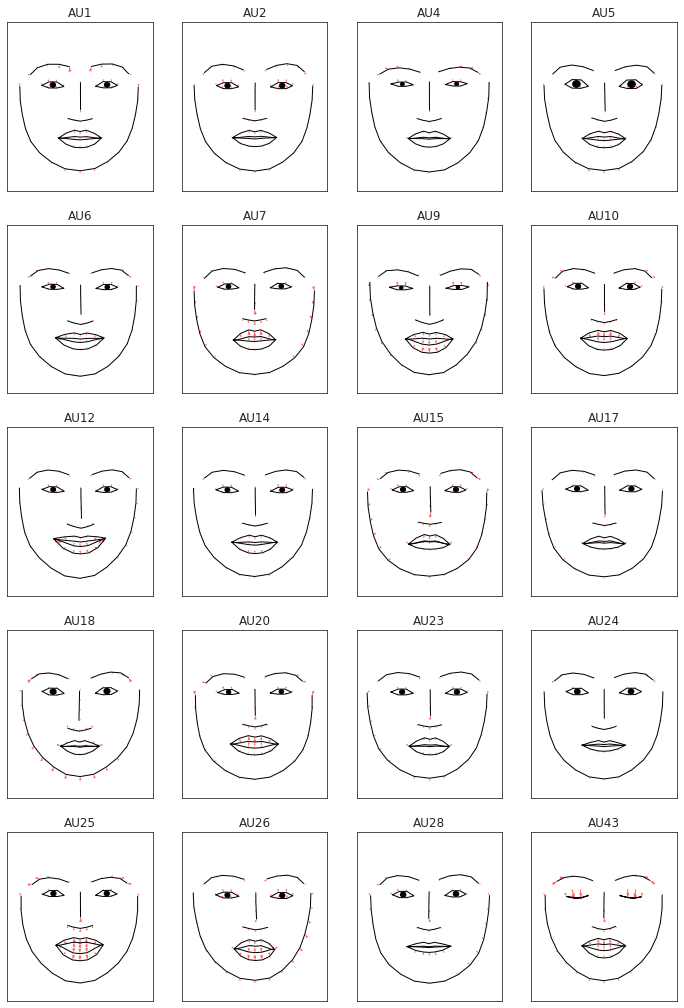

In [10]:
# Plot results for each action unit
f,axes = plt.subplots(5,4,figsize=(12,18))
axes = axes.flatten()
# Exaggerate the intensity of the expression for clearer visualization. 
# We do not recommend exceeding 2. 
intensity = 2
for aui, auname in enumerate(axes):
    try:
        auname=au_cols[aui]
        au = np.zeros(clf.n_components)
        au[aui] = intensity
        predicted = clf.predict([au]).reshape(2,68)
        plot_face(au=au, model=clf,
                  vectorfield={"reference": neutral.T, 'target': predicted,
                               'color':'r','alpha':.6},
                 ax = axes[aui])
        axes[aui].set(title=auname)
    except:
        pass
    finally:
        ax = axes[aui]
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

Here is how we would export our model into an h5 format which can be loaded using our load_h5 function. 

In [ ]:
# save out trained model
# import h5py
# hf = h5py.File('../feat/resources/pyfeat_aus_to_landmarks.h5', 'w')
# hf.create_dataset('coef', data=clf.coef_)
# hf.create_dataset('x_mean', data=clf._x_mean)
# hf.create_dataset('x_std', data=clf._x_std)
# hf.create_dataset('y_mean', data=clf._y_mean)
# hf.close()

Load h5 model

In [4]:
from feat.utils import load_h5
clf = load_h5('../../feat/resources/pyfeat_aus_to_landmarks.h5')

## Preprocessing datasets
Here we provide sample code for how you might preprocess the datasets to be used in this tutorial. 



In [ ]:
from PIL import Image, ImageOps
import math, cv2, csv
from scipy.spatial import ConvexHull
from skimage.morphology.convex_hull import grid_points_in_poly
from feat import Detector
import os, glob, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from skimage import data, exposure
from skimage.feature import hog
from tqdm import tqdm

def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size - img.size[0]
    delta_height = desired_size - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

def resize_with_padding(img, expected_size):
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

def align_face_68pts(img, img_land, box_enlarge, img_size=112):
    """
    img: image
    img_land: landmarks 68
    box_enlarge: relative size of face
    img_size = 112
    
    """
    leftEye0 = (img_land[2 * 36] + img_land[2 * 37] + img_land[2 * 38] + img_land[2 * 39] + img_land[2 * 40] +
                img_land[2 * 41]) / 6.0
    leftEye1 = (img_land[2 * 36 + 1] + img_land[2 * 37 + 1] + img_land[2 * 38 + 1] + img_land[2 * 39 + 1] +
                img_land[2 * 40 + 1] + img_land[2 * 41 + 1]) / 6.0
    rightEye0 = (img_land[2 * 42] + img_land[2 * 43] + img_land[2 * 44] + img_land[2 * 45] + img_land[2 * 46] +
                 img_land[2 * 47]) / 6.0
    rightEye1 = (img_land[2 * 42 + 1] + img_land[2 * 43 + 1] + img_land[2 * 44 + 1] + img_land[2 * 45 + 1] +
                 img_land[2 * 46 + 1] + img_land[2 * 47 + 1]) / 6.0
    deltaX = (rightEye0 - leftEye0)
    deltaY = (rightEye1 - leftEye1)
    l = math.sqrt(deltaX * deltaX + deltaY * deltaY)
    sinVal = deltaY / l
    cosVal = deltaX / l
    mat1 = np.mat([[cosVal, sinVal, 0], [-sinVal, cosVal, 0], [0, 0, 1]])
    mat2 = np.mat([[leftEye0, leftEye1, 1], [rightEye0, rightEye1, 1], [img_land[2 * 30], img_land[2 * 30 + 1], 1],
                   [img_land[2 * 48], img_land[2 * 48 + 1], 1], [img_land[2 * 54], img_land[2 * 54 + 1], 1]])
    mat2 = (mat1 * mat2.T).T
    cx = float((max(mat2[:, 0]) + min(mat2[:, 0]))) * 0.5
    cy = float((max(mat2[:, 1]) + min(mat2[:, 1]))) * 0.5
    if (float(max(mat2[:, 0]) - min(mat2[:, 0])) > float(max(mat2[:, 1]) - min(mat2[:, 1]))):
        halfSize = 0.5 * box_enlarge * float((max(mat2[:, 0]) - min(mat2[:, 0])))
    else:
        halfSize = 0.5 * box_enlarge * float((max(mat2[:, 1]) - min(mat2[:, 1])))
    scale = (img_size - 1) / 2.0 / halfSize
    mat3 = np.mat([[scale, 0, scale * (halfSize - cx)], [0, scale, scale * (halfSize - cy)], [0, 0, 1]])
    mat = mat3 * mat1
    aligned_img = cv2.warpAffine(img, mat[0:2, :], (img_size, img_size), cv2.INTER_LINEAR, borderValue=(128, 128, 128))
    land_3d = np.ones((int(len(img_land)/2), 3))
    land_3d[:, 0:2] = np.reshape(np.array(img_land), (int(len(img_land)/2), 2))
    mat_land_3d = np.mat(land_3d)
    new_land = np.array((mat * mat_land_3d.T).T)
    new_land = np.array(list(zip(new_land[:,0], new_land[:,1]))).astype(int)
    return aligned_img, new_land

def extract_hog(image, detector):
    im = cv2.imread(image)
    detected_faces = np.array(detector.detect_faces(im)[0])
    if np.any(detected_faces<0):
        orig_size = np.array(im).shape
        if np.where(detected_faces<0)[0][0]==1: 
            new_size = (orig_size[0], int(orig_size[1] + 2*abs(detected_faces[detected_faces<0][0])))
        else:
            new_size = (int(orig_size[0] + 2*abs(detected_faces[detected_faces<0][0])), orig_size[1])
        im = resize_with_padding(Image.fromarray(im), new_size)
        im = np.asarray(im)
        detected_faces = np.array(detector.detect_faces(np.array(im))[0])
    detected_faces = detected_faces.astype(int)
    points = detector.detect_landmarks(np.array(im), [detected_faces])[0].astype(int)

    aligned_img, points = align_face_68pts(im, points.flatten(), 2.5)

    hull = ConvexHull(points)
    mask = grid_points_in_poly(shape=np.array(aligned_img).shape, 
                               verts= list(zip(points[hull.vertices][:,1], points[hull.vertices][:,0])) # for some reason verts need to be flipped
                               )

    mask[0:np.min([points[0][1], points[16][1]]), points[0][0]:points[16][0]] = True
    aligned_img[~mask] = 0
    resized_face_np = aligned_img

    fd, hog_image = hog(resized_face_np, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True, multichannel=True)

    return fd, hog_image, points

Replace the paths so that it points to your local dataset directory.

In [ ]:
detector = Detector(face_model = "retinaface", landmark_model="mobilenet")
# Correct path to your downloaded dataset.
EmotioNet_images = np.sort(glob.glob("/Storage/Data/EmotioNet/imgs/*.jpg"))
labels = pd.read_csv("/Storage/Data/EmotioNet/labels/EmotioNet_FACS_aws_2020_24600.csv")
labels = labels.dropna(axis=0)
for col in labels.columns:
    if "AU" in col:
        kwargs = {col.replace("'", '').replace('"', '').replace(" ",""): labels[[col]]}
        labels = labels.assign(**kwargs)
        labels = labels.drop(columns = col)
labels = labels.assign(URL = labels.URL.apply(lambda x: x.split("/")[-1].replace("'", "")))
labels = labels.set_index('URL')
labels = labels.drop(columns = ["URL orig"])

aus_to_train = ['AU1','AU2','AU4','AU5', "AU6", "AU9","AU10", "AU12", "AU15","AU17", 
                "AU18","AU20", "AU24", "AU25", "AU26", "AU28", "AU43"]

with open('emotionet_labels.csv', "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["URL"] + aus_to_train)
    
landmark_cols = [f"x_{i}" for i in range(68)] + [f"y_{i}" for i in range(68)]
with open('emotionet_landmarks.csv', "w", newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(landmark_cols)
    
for ix, image in enumerate(tqdm(EmotioNet_images)):
    try:
        imageURL = os.path.split(image)[-1]
        label = labels.loc[imageURL][aus_to_train]
        fd, _, points = extract_hog(image, detector=detector)
        with open('emotionet_labels.csv', "a+", newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            writer.writerow([imageURL]+list(label.values))
        with open('emotionet_landmarks.csv', "a+", newline='') as csvfile:
            writer = csv.writer(csvfile, delimiter=',')
            writer.writerow(points.T.flatten())
    except:
        print(f"failed {image}")